## 은행 고객 이탈 예측

Kaggle에서 진행한 playground 대회

### 데이터셋
해당 대회의 데이터셋은 은행 고객 이탈 예측 데이터세트에 의해 훈련된 딥러닝 모델에서 생성된 데이터셋이다. 이번 대회를 통홰 원본 데이터 세트와 모델에서 생성된 데이터셋의 차이점을 탐색하고 원본 데이터에 학습되어 나온 데이터셋을 병합하면 모델 성능이 향상되는지 확인하는 것이 목표라고 한다.

각 컬럼이 의미하는 바는 아래와 같다.

|columns|explain|
|---|---|
|Customer ID|각 고객이 가지는 고유 ID값|
|Surname|고객의 성 또는 이름|
|Credit Score|고객의 신용 점수|
|Geography|고객이 거주하는 국가|
|Gender|성별|
|Age|나이|
|Tenure|해당 고객이 은행을 사용한 연차|
|Balance|고객의 계좌 잔액|
|NumOfProducts|고객이 은행에서 사용하는 상품의 개수(ex.저축 계좌, 신용카드 등..)|
|HasCrCard|해당 고객의 신용카드 소지여부|
|IsActiveMember|해당 고객이 은행에서 거래 등의 활동을 하는지에 대한 여부|
|EstimatedSalary|고객의 예상 급여|
|Exited|고객이 해당 은행에서 이탈했는지 여부(Target값)|

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import shap

import warnings
warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
train_data = pd.read_csv("./data/train.csv")
test_data = pd.read_csv("./data/test.csv")
sample_submission = pd.read_csv("./data/sample_submission.csv")
original_data = pd.read_csv("./data/Churn_Modelling.csv")

In [3]:
train_data.head(10)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
5,5,15771669,Genovese,588,Germany,Male,36.0,4,131778.58,1,1.0,0.0,136024.31,1
6,6,15692819,Ch'ang,593,France,Female,30.0,8,144772.69,1,1.0,0.0,29792.11,0
7,7,15669611,Chukwuebuka,678,Spain,Male,37.0,1,138476.41,1,1.0,0.0,106851.60,0
8,8,15691707,Manna,676,France,Male,43.0,4,0.00,2,1.0,0.0,142917.13,0
9,9,15591721,Cattaneo,583,Germany,Male,40.0,4,81274.33,1,1.0,1.0,170843.07,0


In [4]:
# 훈련 데이터셋을 전치하여 색상을 달리하여 시각화한다. 값이 클수록 진해진다.
train_data.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
id,165034.000000,82516.500000,47641.356500,0.000000,41258.250000,82516.500000,123774.750000,165033.000000
CustomerId,165034.000000,15692005.019026,71397.816791,15565701.000000,15633141.000000,15690169.000000,15756824.000000,15815690.000000
CreditScore,165034.000000,656.454373,80.103340,350.000000,597.000000,659.000000,710.000000,850.000000
Age,165034.000000,38.125888,8.867205,18.000000,32.000000,37.000000,42.000000,92.000000
Tenure,165034.000000,5.020353,2.806159,0.000000,3.000000,5.000000,7.000000,10.000000
Balance,165034.000000,55478.086689,62817.663278,0.000000,0.000000,0.000000,119939.517500,250898.090000
NumOfProducts,165034.000000,1.554455,0.547154,1.000000,1.000000,2.000000,2.000000,4.000000
HasCrCard,165034.000000,0.753954,0.430707,0.000000,1.000000,1.000000,1.000000,1.000000
IsActiveMember,165034.000000,0.497770,0.499997,0.000000,0.000000,0.000000,1.000000,1.000000
EstimatedSalary,165034.000000,112574.822734,50292.865585,11.580000,74637.570000,117948.000000,155152.467500,199992.480000


In [5]:
test_data.head(10)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00
5,165039,15672704,Pearson,593,France,Female,22.0,9,0.00,2,0.0,0.0,51907.72
6,165040,15647838,Onyemere,682,Spain,Male,45.0,4,0.00,2,1.0,1.0,157878.67
7,165041,15775307,Hargreaves,539,Spain,Female,47.0,8,0.00,2,1.0,1.0,126784.29
8,165042,15653937,Hsueh,845,France,Female,47.0,3,111096.91,1,1.0,0.0,94978.10
9,165043,15752344,Teng,645,Spain,Male,30.0,5,0.00,2,0.0,1.0,149195.44


In [6]:
test_data.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
id,110023.000000,220045.000000,31761.048671,165034.000000,192539.500000,220045.000000,247550.500000,275056.000000
CustomerId,110023.000000,15692096.605101,71684.990992,15565701.000000,15632859.000000,15690175.000000,15756926.000000,15815690.000000
CreditScore,110023.000000,656.530789,80.315415,350.000000,597.000000,660.000000,710.000000,850.000000
Age,110023.000000,38.122205,8.861550,18.000000,32.000000,37.000000,42.000000,92.000000
Tenure,110023.000000,4.996637,2.806148,0.000000,3.000000,5.000000,7.000000,10.000000
Balance,110023.000000,55333.611354,62788.519675,0.000000,0.000000,0.000000,120145.605000,250898.090000
NumOfProducts,110023.000000,1.553321,0.544714,1.000000,1.000000,2.000000,2.000000,4.000000
HasCrCard,110023.000000,0.753043,0.431244,0.000000,1.000000,1.000000,1.000000,1.000000
IsActiveMember,110023.000000,0.495233,0.499980,0.000000,0.000000,0.000000,1.000000,1.000000
EstimatedSalary,110023.000000,112315.147765,50277.048244,11.580000,74440.325000,117832.230000,154631.350000,199992.480000


In [7]:
original_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
original_data.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.000000,5000.500000,2886.895680,1.000000,2500.750000,5000.500000,7500.250000,10000.000000
CustomerId,10000.000000,15690940.569400,71936.186123,15565701.000000,15628528.250000,15690738.000000,15753233.750000,15815690.000000
CreditScore,10000.000000,650.528800,96.653299,350.000000,584.000000,652.000000,718.000000,850.000000
Age,10000.000000,38.921800,10.487806,18.000000,32.000000,37.000000,44.000000,92.000000
Tenure,10000.000000,5.012800,2.892174,0.000000,3.000000,5.000000,7.000000,10.000000
Balance,10000.000000,76485.889288,62397.405202,0.000000,0.000000,97198.540000,127644.240000,250898.090000
NumOfProducts,10000.000000,1.530200,0.581654,1.000000,1.000000,1.000000,2.000000,4.000000
HasCrCard,10000.000000,0.705500,0.455840,0.000000,0.000000,1.000000,1.000000,1.000000
IsActiveMember,10000.000000,0.515100,0.499797,0.000000,0.000000,1.000000,1.000000,1.000000
EstimatedSalary,10000.000000,100090.239881,57510.492818,11.580000,51002.110000,100193.915000,149388.247500,199992.480000


### 데이터 분석
EDA 시작

In [9]:
train_data.isna().sum().sum()

0

In [10]:
test_data.isna().sum().sum()

0

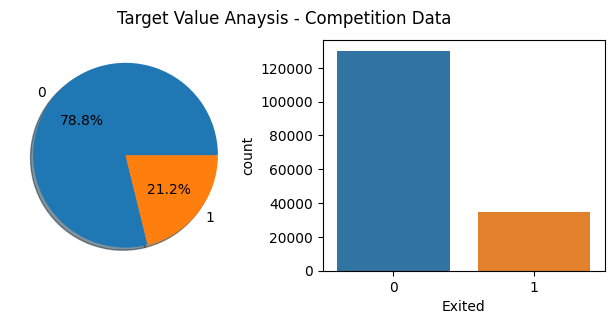

In [11]:
# 타겟값 분포 확인
f,ax=plt.subplots(1,2,figsize=(8,3))
train_data['Exited'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_ylabel('')
sns.countplot(x='Exited',data=train_data,ax=ax[1])
plt.suptitle('Target Value Anaysis - Competition Data')
plt.show()

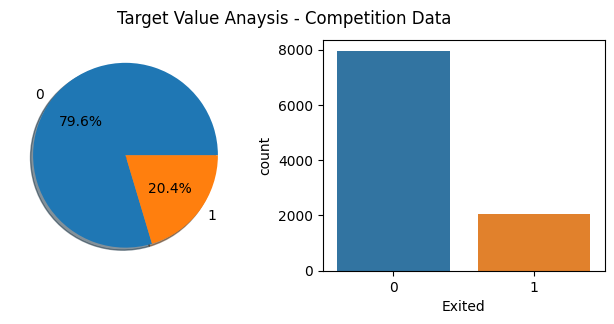

In [12]:
f,ax=plt.subplots(1,2,figsize=(8,3))
original_data['Exited'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_ylabel('')
sns.countplot(x='Exited',data=original_data,ax=ax[1])
plt.suptitle('Target Value Anaysis - Competition Data')
plt.show()

- 학습에 의해 생성된 데이터셋과 원본 데이터셋의 타겟값 분포는 비슷한 편이다.
- 타겟값의 분포가 굉장히 불균형하다.

### 범주형 데이터 분포확인

In [13]:
unique_counts = train_data.nunique()
threshold = 12  # 수치형 컬럼과 범주형 컬럼을 구분하는 임곗값

continuous_vars = unique_counts[unique_counts > threshold].index.tolist()
categorical_vars = unique_counts[unique_counts <= threshold].index.tolist()

if 'outcome' in categorical_vars:
    categorical_vars.remove('outcome')
if 'id' in continuous_vars:
    continuous_vars.remove('id')

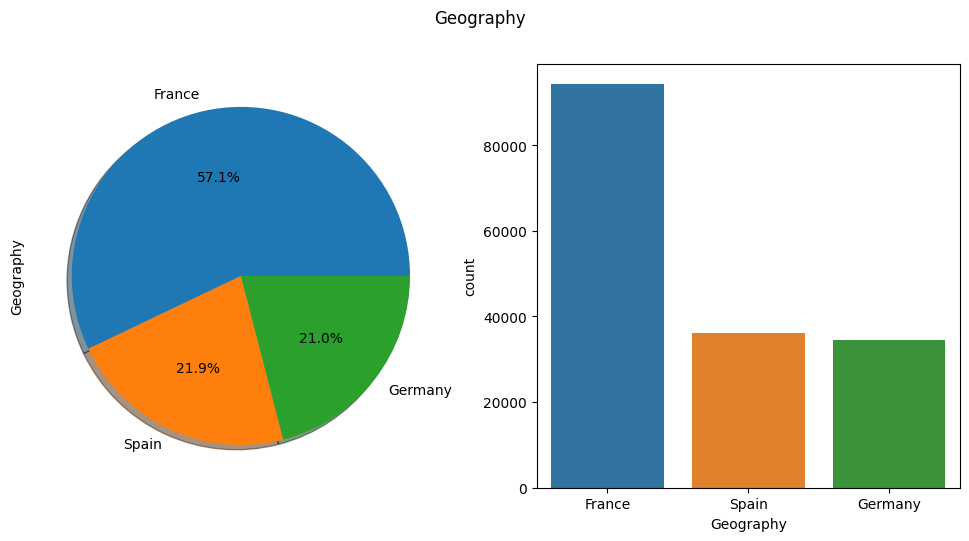

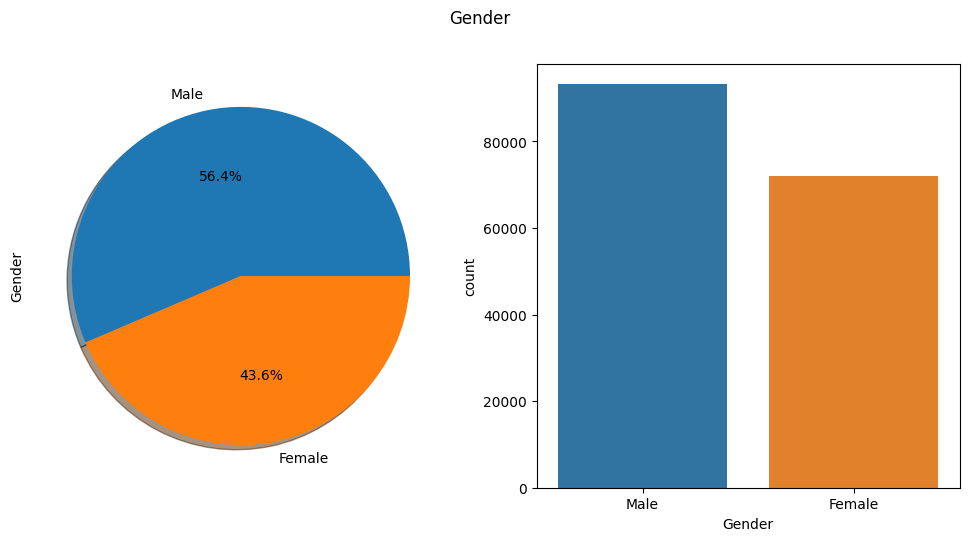

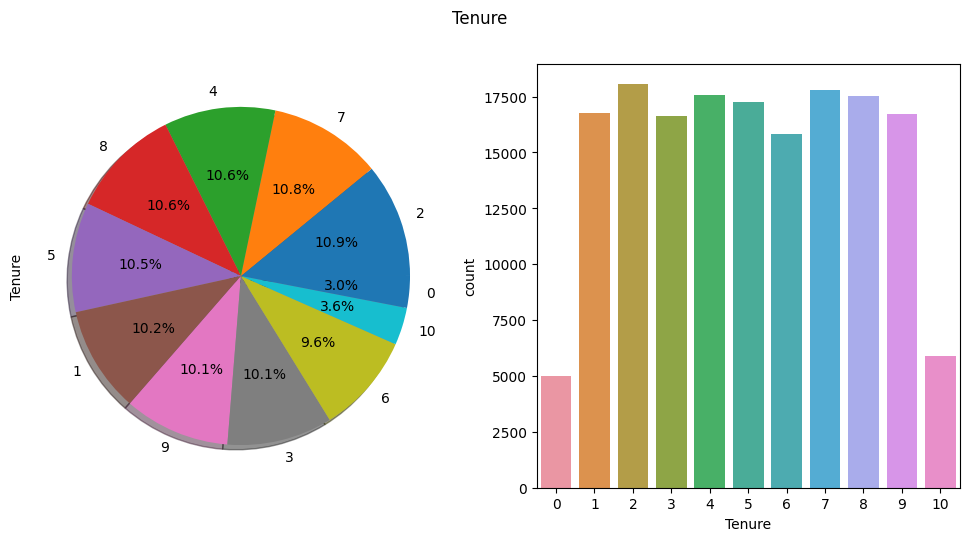

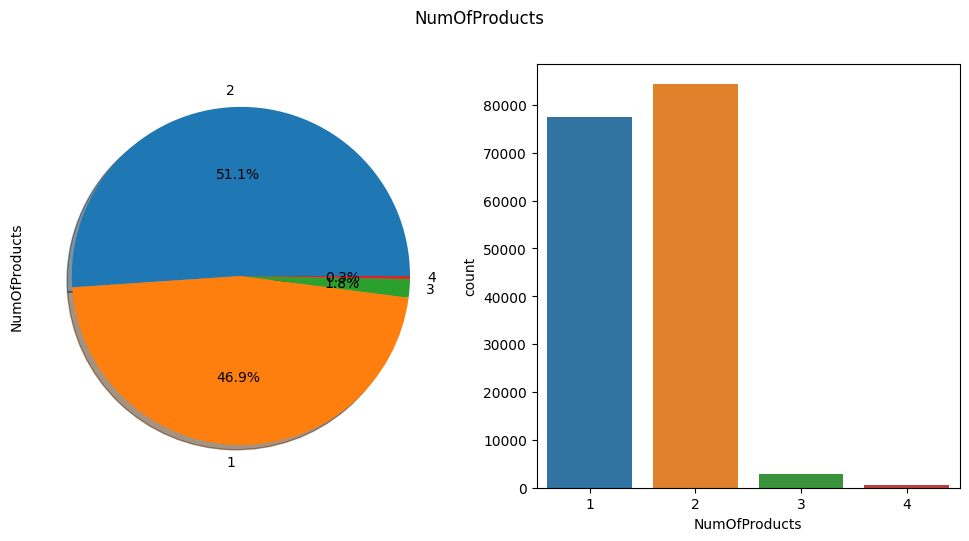

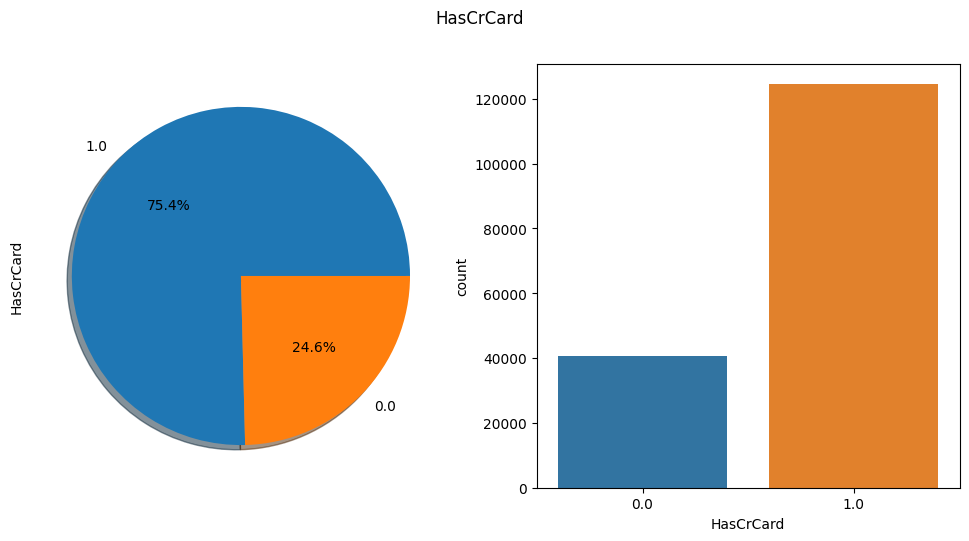

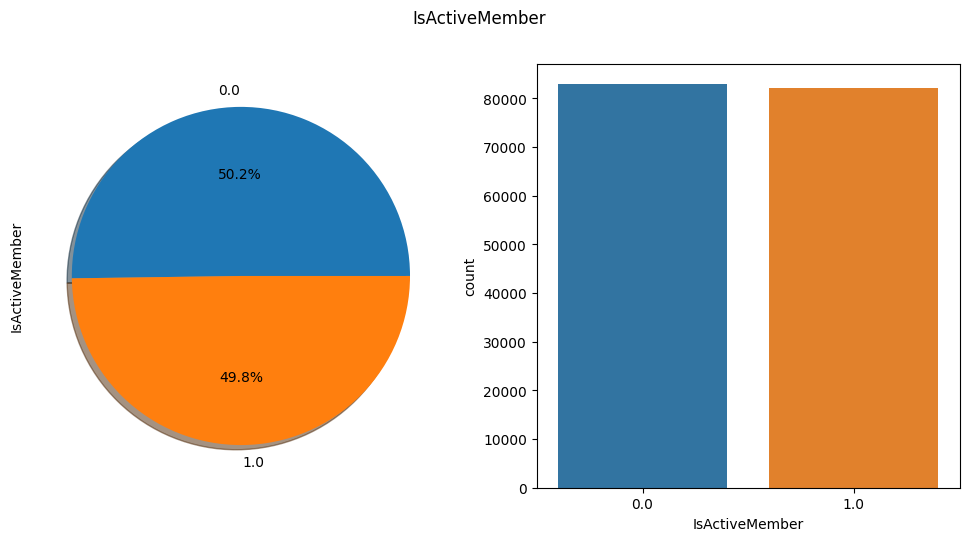

In [14]:
categorical_vars.remove('Exited')

for column in categorical_vars:
    f,ax=plt.subplots(1,2,figsize=(12,5.5))
    train_data[column].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
    ax[0].set_ylabel(f'{column}')
    sns.countplot(x=column,data=train_data,ax=ax[1])
    plt.suptitle(f'{column}')
    plt.show()

- 몇몇 범주형 데이터의 경우 균등한 분포를 이루는 반면, 몇 데이터의 경우 불균형한 분포를 이루고 있다.
- Tenure 컬럼의 경우 연속형 데이터로 보이지만, 0~10까지의 11개의 클래스로 이뤄진 범주형 데이터이다.

### 연속형 데이터
데이터셋에 연속형 자료형의 경우 아래와 같은 컬럼들이 있다.
- CreditScore
- Age
- Balance
- EstimatedSalary

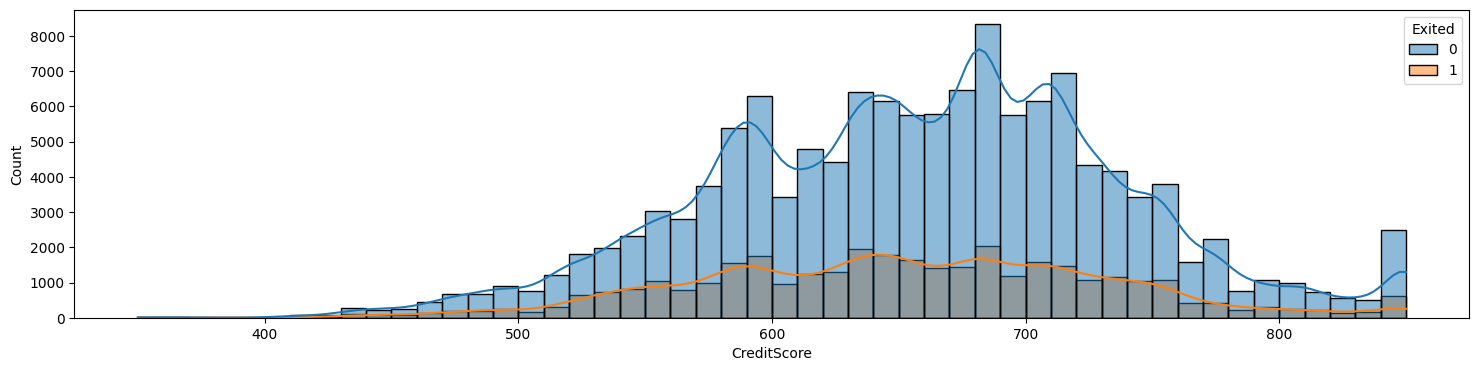

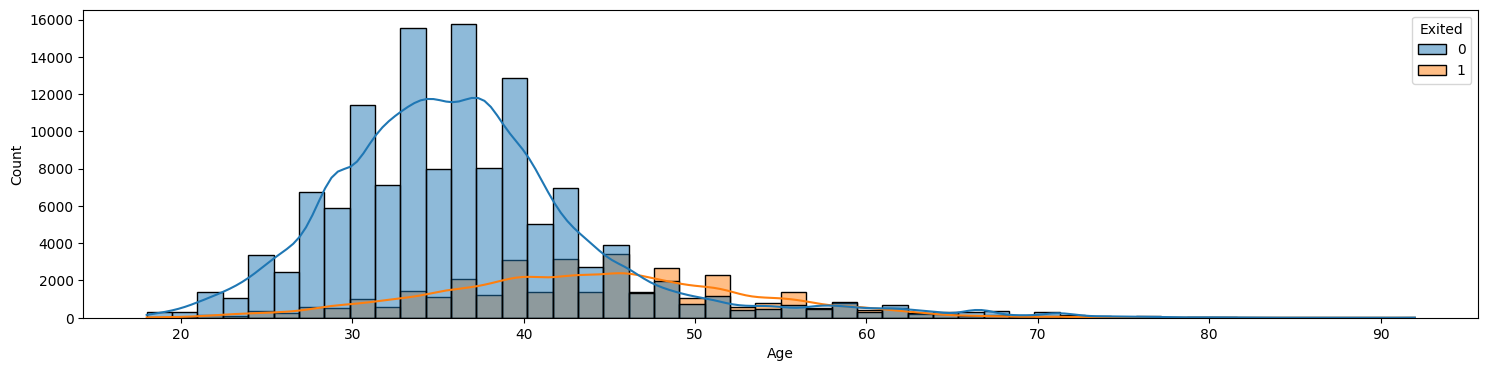

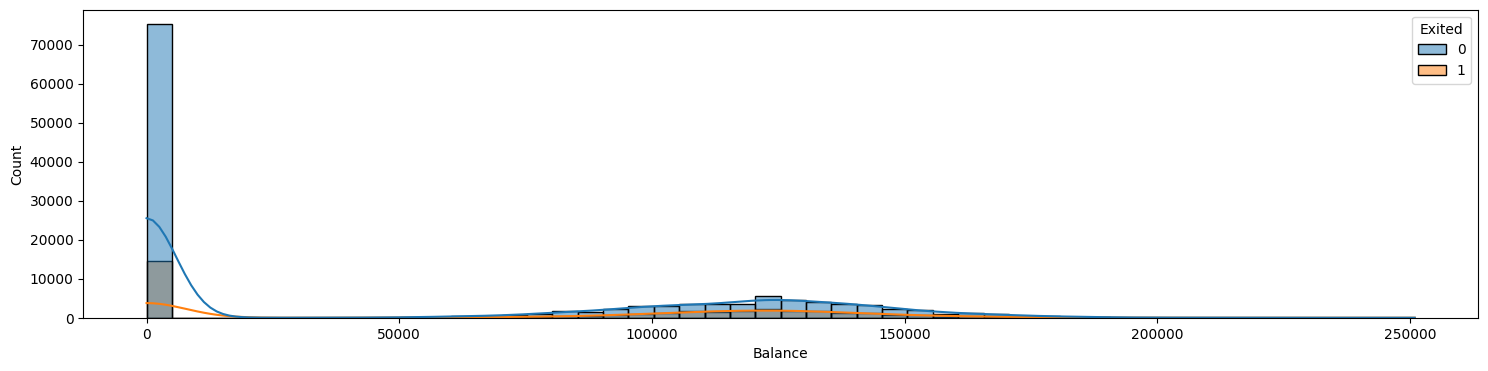

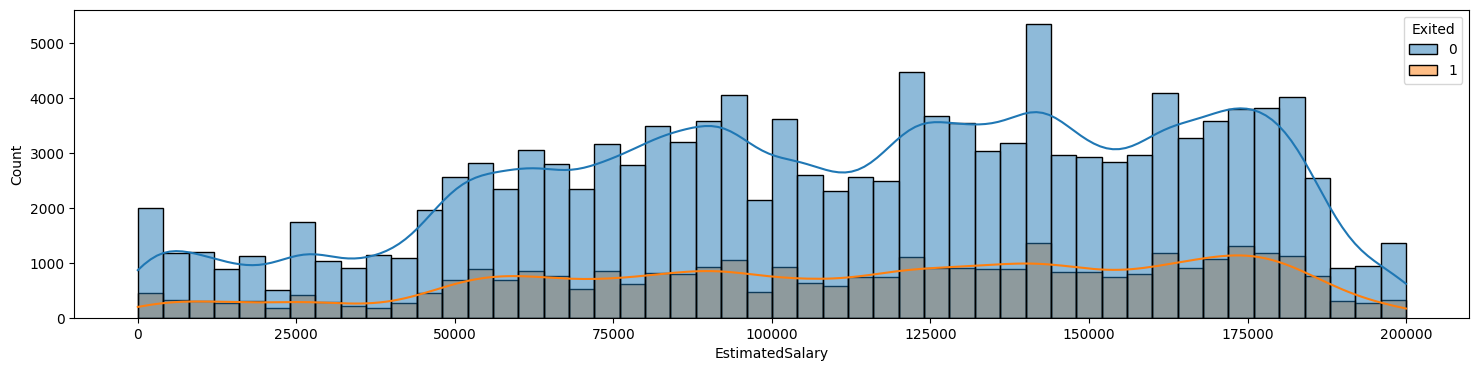

In [15]:
continuous_vars.remove('CustomerId')
continuous_vars.remove('Surname')

for column in continuous_vars:
    fig, ax = plt.subplots(figsize=(18, 4))
    fig = sns.histplot(data=train_data, x=column, hue="Exited", bins=50, kde=True)
    plt.show()

## 모델링
XGBoost를 이용하여 모델링을 진행합니다. 이 모델을 이해하기 위해 선행되는 몇 가지 지식이 있습니다.

1. Decision Tree
    - 의사결정트리는 플로우차트와 같은 트리 구조로서, 각 내부 노드는 속성에 대한 테스트를 나타내고, 각 분기는 테스트의 결과를 나타내며 각 리프 노트는 클래스 레이블을 보유한다.
    - 의사 결정 나무는 가장 쉽게 해석할 수 있는 모델 중 하나로 매우 가변적인 행동을 보인다.

2. Boosting
    - 앙상블 기법 중 하나로 sequential한 weak linear모델들을 여러 개 결합하여 예측, 혹은 분류 성능을 높이는 알고리즘입니다.
    - 여러 개의 약한 분류기가 순차적으로 학습하며, 앞에서 학습한 분류기가 예측이 틀린 데이터에 대해 다음 분류기가 가중치를 인가해서 학습을 이어 진행하는 방식
        + 예측 성능이 뛰어나서 앙상블 학습을 주도하고 있다.
        + 그래디언트 부스트, XGBoost, LightGBM

3. Gradient Boosting
    - 그래디언트 부스팅은 세 가지 기술적 단계를 거칩니다.
        + 1. 초기 모형인 F<sub>0</sub>는 타겟값인 y를 예측하기 위해서 정의 됩니다. 이 모형은 차후 잔차(y-F<sub>0</sub>)와 연관됩니다.
        + 2. 새로운 모델인 H<sub>1</sub>은 이전 단계의 잔차로부터 학습됩니다.
        + 3. F<sub>0</sub>와 H<sub>1</sub>을 결합하여 부스팅 된 단계인 F<sub>1</sub>을 얻습니다. F<sub>1</sub>의 MSE값은 F<sub>0</sub>의 MSE값보다 작습니다.
        > F<sub>1</sub> = F<sub>0</sub> + H<sub>1</sub>
    - F<sub>1</sub>의 성능을 향상시키기 위해 F<sub>1</sub>의 잔차를 기반으로 모델링하고, 새로운 모델 F<sub>2</sub>를 만듭니다.
    > F<sub>2</sub> = F<sub>1</sub> + H<sub>2</sub>
    - 이러한 작업을 잔차가 최소화될 때 까지 N번 반복합니다.
    > F<sub>n</sub> = F<sub>n-1</sub> + H<sub>n</sub>

## 데이터셋 준비
학습을 위한 데이터셋을 구성합니다.
> ID, CustomerID와 Surname열은 제거하고 진행합니다.

In [16]:
X = train_data.drop(['id', 'CustomerId', 'Surname', 'Exited'], axis=1)
y = train_data['Exited']

In [17]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83


In [18]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Exited, dtype: int64

## 범주형 변수 인코딩

In [19]:
X_encoded = pd.get_dummies(X, columns=["Geography", "Gender", "IsActiveMember", "HasCrCard", "NumOfProducts"])
X_encoded.head()

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,IsActiveMember_0.0,IsActiveMember_1.0,HasCrCard_0.0,HasCrCard_1.0,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
0,668,33.0,3,0.00,181449.97,1,0,0,0,1,1,0,0,1,0,1,0,0
1,627,33.0,1,0.00,49503.50,1,0,0,0,1,0,1,0,1,0,1,0,0
2,678,40.0,10,0.00,184866.69,1,0,0,0,1,1,0,0,1,0,1,0,0
3,581,34.0,2,148882.54,84560.88,1,0,0,0,1,0,1,0,1,1,0,0,0
4,716,33.0,5,0.00,15068.83,0,0,1,0,1,0,1,0,1,0,1,0,0


## 데이터셋 분할하기

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)

In [21]:
clf_xgb_v1 = xgb.XGBClassifier(objective='binary:logistic', seed=42)

clf_xgb_v1.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.87445
[1]	validation_0-auc:0.87999
[2]	validation_0-auc:0.88233
[3]	validation_0-auc:0.88342
[4]	validation_0-auc:0.88487
[5]	validation_0-auc:0.88564
[6]	validation_0-auc:0.88621
[7]	validation_0-auc:0.88632
[8]	validation_0-auc:0.88680
[9]	validation_0-auc:0.88694
[10]	validation_0-auc:0.88709
[11]	validation_0-auc:0.88743
[12]	validation_0-auc:0.88752
[13]	validation_0-auc:0.88772
[14]	validation_0-auc:0.88781
[15]	validation_0-auc:0.88799
[16]	validation_0-auc:0.88795
[17]	validation_0-auc:0.88805
[18]	validation_0-auc:0.88813
[19]	validation_0-auc:0.88818
[20]	validation_0-auc:0.88824
[21]	validation_0-auc:0.88822
[22]	validation_0-auc:0.88829
[23]	validation_0-auc:0.88823
[24]	validation_0-auc:0.88829
[25]	validation_0-auc:0.88835
[26]	validation_0-auc:0.88836
[27]	validation_0-auc:0.88836
[28]	validation_0-auc:0.88837
[29]	validation_0-auc:0.88838
[30]	validation_0-auc:0.88835
[31]	validation_0-auc:0.88828
[32]	validation_0-auc:0.88821
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

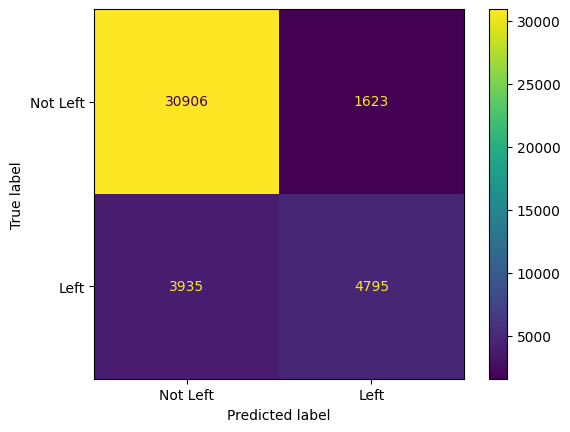

In [22]:
predictions_1 = clf_xgb_v1.predict(X_test)

# sns.set(font_scale=1)
cm = confusion_matrix(y_test, predictions_1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Left', 'Left'])
disp.plot()
plt.show()